In [4]:
import torch
print(torch.cuda.is_available())

True


In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
import logging
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### **Preproccessing the Data**

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return image, label

In [2]:
def split_into_train_validation_test(df: pd.DataFrame, random_state: int, test_size: float):
    # X - pixels of images
    pixels = [col for col in df.columns if col.startswith('pixel')]
    X = df[pixels]
    y = np.array(df['label'])
    
    # Split into train & test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state)
    # Split into train & validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = test_size, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def data_preparation(data: pd.DataFrame, labels, device='cuda'):
    # Reshape the data to match the image dimensions (3, 32, 32)
    data = data.values.reshape(-1, 3, 32, 32)

    # Convert data to float32 and normalize to the range [0, 1]
    data = data.astype(np.float32) / 255.0

    # Convert NumPy arrays to PyTorch tensors
    data_tensors = torch.tensor(data).to(device)
    label_tensors = torch.tensor(labels).to(device)
    
    # Standardize
    normalize_transform = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[1.0, 1.0, 1.0])

    # Create a CustomDataset instance
    dataset = CustomDataset(data_tensors, label_tensors)

    # Create a DataLoader
    batch_size = 32
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader

In [7]:
# df_imbalance = pd.read_csv("/kaggle/input/cifar-10-and-3-classes-from-cifar-100-imbalance/dataset.csv")
# X_train_imbalance, X_val_imbalance, X_test_imbalance, y_train_imbalance, y_val_imbalance, y_test_imbalance = split_into_train_validation_test(df_imbalance, random_state = 42, test_size = 0.2)
# train_loader_imbalance = data_preparation(X_train_imbalance, y_train_imbalance)
# val_loader_imbalance = data_preparation(X_val_imbalance, y_val_imbalance)
# test_loader_imbalance = data_preparation(X_test_imbalance, y_test_imbalance)

In [8]:
df = pd.read_csv("/kaggle/input/perfect-dataset/perfect_dataset.csv")
X_train, X_val, X_test, y_train, y_val, y_test = split_into_train_validation_test(df, random_state = 66, test_size = 0.2)
train_loader = data_preparation(X_train, y_train)
val_loader = data_preparation(X_val, y_val)
test_loader = data_preparation(X_test, y_test)

## Resnet18 model - Tensorboard

In [9]:
import torchvision.models as models
import torch.nn as nn
import os
from tensorboardX import SummaryWriter
from sklearn.metrics import confusion_matrix

In [10]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [11]:
# def append_dropout(model, rate=0.2):
#     for name, module in model.named_children():
#         if len(list(module.children())) > 0:
#             append_dropout(module)
#         if isinstance(module, nn.ReLU):
#             new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=True))
#             setattr(model, name, new)

In [11]:
def compute_confusion_matrix(model, data_loader, labels_df: pd.DataFrame, num_classes:int, device = "cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    class_names = [df.loc[i + 1] for i in range(num_classes)]  # Replace 'num_classes' with the actual number of classes
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return conf_matrix, class_names

In [12]:
def resnet18_model_with_tensorboard(num_epochs: int, train_loader, val_loader, num_classes: int, device='cuda'):
    # Define the ResNet18 model
    model = models.resnet18(pretrained=False).to(device)
    model.fc = nn.Linear(512, num_classes).to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

    # Set up TensorBoard writer
    writer = SummaryWriter('logs')
    os.makedirs('/kaggle/working/MyResNet18Models')

    num_train_batches = len(train_loader)
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Calculate average training loss for the epoch
        train_loss /= num_train_batches
        
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        num_val_batches = len(val_loader)

        with torch.no_grad():  
            for batch_idx, (val_inputs, val_labels) in enumerate(val_loader):
                val_outputs = model(val_inputs)
                val_loss_batch = criterion(val_outputs, val_labels)
                val_loss += val_loss_batch.item()

        val_loss /= num_val_batches
        
        train_accuracy = evaluate_model(model, train_loader)
        val_accuracy = evaluate_model(model, val_loader)

        # Write to TensorBoard
        writer.add_scalars('Loss', {'Train': train_loss, 'Validation': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Validation': val_accuracy}, epoch)
        
#         if (epoch + 1) % 20 == 0 or epoch == num_epochs:
        torch.save(model.state_dict(), f'/kaggle/working/MyResNet18Models/resnet18_model_{epoch + 1}.pth')
        
    # Close the TensorBoard writer
    writer.close()
    
    return model

In [22]:
# import shutil
# shutil.rmtree("/kaggle/working/MyResNet18Models")
# shutil.rmtree("/kaggle/working/logs")
# import os
# os.remove("/kaggle/working/imbalnceData.zip")

In [ ]:
# imbalance_model = resnet18_model_with_tensorboard(30, train_loader_imbalance, val_loader_imbalance, 13)

In [21]:
# imbalance_data_accuracy = evaluate_model(imbalance_model, val_loader_imbalance)
# print("Test Accuracy: {:.2f}%".format(imbalance_data_accuracy))

Test Accuracy: 40.81%


In [23]:
model = resnet18_model_with_tensorboard(30, train_loader, val_loader, 13)

In [24]:
accuracy = evaluate_model(model, val_loader)
print("Test Accuracy: {:.2f}%".format(accuracy))

Test Accuracy: 37.60%


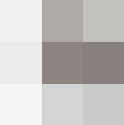

In [15]:
import random
df_pixels = df[filter(lambda x: x.startswith('pixel') == True, df.columns)]
fig, ax = plt.subplots(figsize=(1,1))
ax.imshow(np.array(df_pixels.iloc[random.choice(range(df_pixels.shape[0]))]).reshape(32,32,3))

In [ ]:
labels_df = pd.read_csv("/kaggle/input/labels-names/dataset_names.csv")
conf_matrix, class_names = compute_confusion_matrix(model_29, val_loader, labels_df, num_classes = 13)
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)

In [26]:
!zip -r imbalnceData.zip /kaggle/working/logs

  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/Accuracy/ (stored 0%)
  adding: kaggle/working/logs/Accuracy/Validation/ (stored 0%)
  adding: kaggle/working/logs/Accuracy/Validation/events.out.tfevents.1690976001.b031da16716c (deflated 56%)
  adding: kaggle/working/logs/Accuracy/Train/ (stored 0%)
  adding: kaggle/working/logs/Accuracy/Train/events.out.tfevents.1690976001.b031da16716c (deflated 56%)
  adding: kaggle/working/logs/events.out.tfevents.1690975980.b031da16716c (deflated 5%)
  adding: kaggle/working/logs/Loss/ (stored 0%)
  adding: kaggle/working/logs/Loss/Validation/ (stored 0%)
  adding: kaggle/working/logs/Loss/Validation/events.out.tfevents.1690976001.b031da16716c (deflated 52%)
  adding: kaggle/working/logs/Loss/Train/ (stored 0%)
  adding: kaggle/working/logs/Loss/Train/events.out.tfevents.1690976001.b031da16716c (deflated 52%)


In [15]:
def load_model(model_path, device='cuda'):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(512, 13)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

In [16]:
model_29 = load_model("/kaggle/input/models-imbalance-data/resnet18_model_29.pth")#"/kaggle/input/models-imbalance-data/resnet18_model_29.pth")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
evaluate_model(model_29, val_loader)

In [ ]:
# model = load_model(model, '/kaggle/working/MyResNet18Models/resnet18_model_29.pth')

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs --host localhost --port 8088

In [5]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet18()

def append_dropout(model, rate=0.2):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=True))
            setattr(model, name, new)


append_dropout(model)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sequential(
    (0): ReLU(inplace=True)
    (1): Dropout2d(p=0.2, inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sequential(
        (0): ReLU(inplace=True)
        (1): Dropout2d(p=0.2, inplace=True)
      )
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [3]:
df = pd.read_csv("/kaggle/input/perfect-dataset/perfect_dataset.csv")
X_train, X_val, X_test, y_train, y_val, y_test = split_into_train_validation_test(df, random_state = 66, test_size = 0.2)

In [6]:
import numpy as np
np.random.seed(123) # for reproducibility

from keras.models import Sequential
from keras.layers import Flatten, MaxPool2D, Conv2D, Dense, Reshape, Dropout
from keras.utils import np_utils

X_train_tf = X_train.values.reshape(X_train.shape[0], 32, 32, 3)
X_val_tf = X_val.values.reshape(X_val.shape[0], 32, 32, 3)
X_test_tf = X_test.values.reshape(X_test.shape[0], 32, 32, 3)
X_train_tf = X_train_tf.astype('float32')
X_val_tf = X_val_tf.astype('float32')
X_test_tf = X_test_tf.astype('float32')
X_train_tf /= 255
X_val_tf /= 255
X_test_tf /= 255
Y_train_tf = np_utils.to_categorical(y_train, 13)
Y_val_tf = np_utils.to_categorical(y_val, 13)
Y_test_tf = np_utils.to_categorical(y_test, 13)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
batch_size = 32
num_classes = 13
epochs = 50
input_shape = (32, 32, 3)

In [ ]:
self.model = Sequential()
self.model.add(Conv2D(64, (3, 3), padding='same',input_shape=input_shape))  # 32*32*64
self.model.add(Activation('relu'))  # 32*32*64
self.model.add(BatchNormalization())  # 32*32*64
self.model.add(Conv2D(64, (3, 3)))  # 32*32*1 ->  30*30*64
self.model.add(Activation('relu'))  # 30*30*64
self.model.add(BatchNormalization())  # 30*30*64
self.model.add(MaxPooling2D(pool_size=(2, 2)))  # 15*15*64
self.model.add(Dropout(0.25))  # 15*15*64
self.model.add(Conv2D(128, (3, 3), padding='same'))   # 15*15*1 -> 15*15*128
self.model.add(Activation('relu'))  # 15*15*128
self.model.add(BatchNormalization())  # 15*15*128
self.model.add(Conv2D(128, (3, 3)))  # 15*15*1 -> 13*13*128
self.model.add(Activation('relu'))  # 13*13*128
self.model.add(BatchNormalization())  # 13*13*128
self.model.add(MaxPooling2D(pool_size=(2, 2)))  # 6*6*128
self.model.add(Dropout(0.25))  # 6*6*128
self.model.add(Flatten())  # 4,608*1*1
self.model.add(Dense(512, kernel_regularizer=l2(0.001)))  # 512*1*1
self.model.add(Activation('relu'))  # 512*1*1
self.model.add(Dropout(0.5))  # 512*1*1
self.model.add(Dense(13))  # 10*1*1
self.model.add(Activation('softmax')) # 10*1*1

In [22]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
hist = model.fit(X_train_tf, Y_train_tf, batch_size = 32, validation_data = (X_val_tf, Y_val_tf) ,epochs = 50, verbose = 1)

Epoch 1/30
1560/1560 [==============================] - 11s 6ms/step - loss: 1.9168 - accuracy: 0.3435 - val_loss: 1.8519 - val_accuracy: 0.3746
Epoch 2/30
1560/1560 [==============================] - 10s 6ms/step - loss: 1.9051 - accuracy: 0.3460 - val_loss: 1.8442 - val_accuracy: 0.3760
Epoch 3/30
1560/1560 [==============================] - 10s 6ms/step - loss: 1.8993 - accuracy: 0.3503 - val_loss: 1.8474 - val_accuracy: 0.3758
Epoch 4/30
1560/1560 [==============================] - 10s 6ms/step - loss: 1.8982 - accuracy: 0.3502 - val_loss: 1.8441 - val_accuracy: 0.3719
Epoch 5/30
1560/1560 [==============================] - 10s 6ms/step - loss: 1.8946 - accuracy: 0.3509 - val_loss: 1.8395 - val_accuracy: 0.3752
Epoch 6/30
1560/1560 [==============================] - 9s 6ms/step - loss: 1.8873 - accuracy: 0.3531 - val_loss: 1.8196 - val_accuracy: 0.3827
Epoch 7/30
1560/1560 [==============================] - 9s 6ms/step - loss: 1.8843 - accuracy: 0.3544 - val_loss: 1.8396 - val_accu